# Risks of Long-term Secondary Malignancies in Breast Cancer Patients Treated with Adjuvant Chemotherapy

[Benjamin Chan](http://careers.stackoverflow.com/benjaminchan)  

In [1]:
message(sprintf("Run date: %s", Sys.time()))

Run date: 2016-06-17 14:51:43


## Load data

Load the data from [GitHub](https://github.com/benjamin-chan/SecMalAfterBreastCaACT).

In [2]:
if (!require(openxlsx)) {install.packages("openxlsx", dependencies=TRUE, repos="https://cloud.r-project.org")}
library(openxlsx)
if (!require(data.table)) {install.packages("data.table", dependencies=TRUE, repos="https://cloud.r-project.org")}
library(data.table)
url <- "https://github.com/benjamin-chan/SecMalAfterBreastCaACT/raw/master/SecondaryMalignancies_Data_BG_3_4.xlsx"
f <- tempfile()
download.file(url, f, mode="wb")
sheets <- getSheetNames(f)
# sheets
D <- read.xlsx(f, sheet = sheets[1], startRow = 3, colNames = FALSE)
D <- data.table(D)
oldnames <- names(D)
newnames <- c("id",
              "authorYear",
              "trial",
              "quality",
              "arm",
              "nRandomized",
              "nITT",
              # "pctCompletingTx",
              "medianFU",
              "regimen",
              "anthracyclineType",
              "anthracyclineTotalDose",
              "anthracyclineDuration",
              "anthracyclineCourses",
              "cyclophosphamideDose",
              "cyclophosphamideDuration",
              "cyclophosphamideCourses",
              "taxaneType",
              "taxaneTotalDose",
              "taxaneDuration",
              "taxaneCourses",
              "fluoroucilTotalDose",
              "fluoroucilDuration",
              "fluoroucilCourses",
              "otherTxDetails",
              "malAML",
              "malMDS",
              "malAMLOrMDS",
              "malNonBreastSolid",
              "malNonBreastSolidType",
              "malOtherBloodCancers",
              "malSMRelatedDeaths",
              "malSecondPrimary",
              "NOTES")
setnames(D, oldnames, newnames[1:33])

Loading required package: openxlsx
Loading required package: data.table


## Tidy data

Create a `rowid` variable.
This will be handy later.

In [3]:
D <- D[, rowid := .I]

Input missing data for Bergh (2000); row was split.

In [4]:
col <- grep("^cyclophosphamide", names(D), invert = TRUE)
D[11, col] <- D[10, col, with = FALSE]
# D[11, ]
# D[10, ]

Fix trial column for Romond (2005).

In [5]:
D <- D[grep("Romond", authorYear), trial := gsub("&N", "& N", trial)]

Make `medianFU` numeric.

In [6]:
D <- D[grep("-", medianFU, invert = TRUE), medianFUNum := round(as.numeric(medianFU), digits = 2)]
x <- D[grep("-", medianFU), medianFU]
x <- as.numeric(unlist(strsplit(x, "-")))
x1 <- x[seq(1, length(x), 2)]
x2 <- x[seq(2, length(x), 2)]
xbar <- rowMeans(cbind(x1, x2))
D <- D[grep("-", medianFU), medianFUNum := xbar]
D <- D[,
       `:=` (medianFUChar = medianFU,
             medianFU = medianFUNum,
             medianFUNum = NULL)]
unique(D[as.character(medianFU) != medianFUChar, .(medianFU, medianFUChar)])
D <- D[, medianFUChar := NULL]

,medianFU,medianFUChar
1,38.3,38.299999999999997
2,73,71-75
3,99.6,99.600000000000009
4,28.8,28.799999999999997


Recode mal* values of `NR` and `-` to `NA`.

In [7]:
recode <- function(x) {
    missval <- c("-", "NR", " ")
    vec <- D[, get(x)]
    vec[vec %in% missval] <- NA
    vec
}
col <- grep("^mal", names(D), value = TRUE)
for (i in 1:length(col)) {
    D[, col[i]] <- recode(col[i])
}

Substitute non-numeric text in mal* values.

In [8]:
substitute <- function(x) {
    vec <- D[, get(x)]
    vec <- gsub("[[:alpha:]]", "", vec)
    vec
}
col <- grep("^mal", names(D), value = TRUE)
for (i in 1:4) {
    # Only substitute a subset of mal* columns
    D[, col[i]] <- substitute(col[i])
}

Convert mal* values to numeric.

In [9]:
for (i in 1:4) {
    # Only convert a subset of mal* columns
    D <- D[, col[i] := as.numeric(get(col[i]))]
}

The `malAMLOrMDS` column, as entered, captures number of AML or MDS malignancies if the study reported them grouped as opposed to separately.
If the study reported them as separately, then these counts are captures in the `malAML` and `malMDS` columns.
I.e., the `malAML`, `malMDS`, and `malAMLOrMDS` columns are mutually exclusive counts.
We want to create another column, `malAMLOrMDSTotal`, to be non-mutually exclusive from `malAML`, `malMDS`, and `malAMLOrMDS`.
If none of the `malAML`, `malMDS`, and `malAMLOrMDS` values are populated, then set `malAMLOrMDSTotal` to `NA`, also.
NOTE: Couldn't get this to work: [http://stackoverflow.com/a/16513949/1427069](http://stackoverflow.com/a/16513949/1427069).

In [10]:
s <- sample(D[, rowid], 12)
malAMLOrMDSTotal <- rowSums(D[, .(malAML, malMDS, malAMLOrMDS)], na.rm=TRUE)
D <- D[, malAMLOrMDSTotal := malAMLOrMDSTotal]
D <- D[is.na(malAML) & is.na(malMDS) & is.na(malAMLOrMDS), malAMLOrMDSTotal := NA]
D[s, .(rowid, malAML, malMDS, malAMLOrMDS, malAMLOrMDSTotal)]

,rowid,malAML,malMDS,malAMLOrMDS,malAMLOrMDSTotal
1,7,5,5,NA,10
2,96,NA,NA,NA,NA
3,73,NA,NA,2,2
4,28,NA,NA,NA,NA
5,91,NA,NA,NA,NA
6,34,0,1,NA,1
7,48,NA,NA,NA,NA
8,52,1,1,NA,2
9,27,NA,NA,NA,NA
10,43,0,NA,NA,0


Remove text from `nITT` column.

In [11]:
D <- D[authorYear == "Misset (1996)" & arm == 2, nITT := "137"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 1, nITT := "210"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 2, nITT := "197"]
D <- D[authorYear == "Fumoleu (2003)" & arm == 3, nITT := "195"]
D <- D[, nITT := as.integer(nITT)]

Clean up the `regimen` and `dose` columns.
Output to [regimens.md](regimens.md) for checking.

In [12]:
D <- D[, regimen := gsub("\\s$", "", regimen)]
D <- D[, regimen := gsub("\\r\\n", " ", regimen)]
doseVar <- grep("dose", names(D), ignore.case = TRUE, value = TRUE)
for (i in 1:length(doseVar)) {
    D <- D[, doseVar[i] := gsub("\\r\\n", " ", get(doseVar[i]))]
}
write.table(D[, .N, c("regimen", doseVar), with = TRUE][order(regimen)],
            file = "regimens.md",
            sep = " | ", quote = FALSE,
            row.names = FALSE)
file.info("regimens.md")

            size isdir mode               mtime               ctime
regimens.md 2150 FALSE  664 2016-06-17 14:51:45 2016-06-17 14:51:45
                          atime  uid  gid  uname grname
regimens.md 2016-06-17 14:37:34 1000 1000 ubuntu ubuntu

Calculate cumulative dose: $\text{total dose} \times \text{number of courses}$.

In [13]:
D <- D[, anthracyclineTotalDose := as.numeric(anthracyclineTotalDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", anthracyclineTotalDose := 75]
D <- D[authorYear == "Henderson (2003)", anthracyclineTotalDose := 75]
D <- D[authorYear == "Colleoni (2009)" & regimen == "AC-CMF", anthracyclineTotalDose := 75]
D <- D[, cyclophosphamideDose := as.numeric(cyclophosphamideDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", cyclophosphamideDose := 900]
D <- D[authorYear == "Henderson (2003)", anthracyclineTotalDose := 75]
D <- D[, taxaneCourses := as.numeric(taxaneCourses)]
D <- D[authorYear == "Shulman (2014)" & regimen == "T" & arm == 3, taxaneCourses := 4]
D <- D[authorYear == "Shulman (2014)" & regimen == "T" & arm == 4, taxaneCourses := 6]
D <- D[, fluoroucilTotalDose := as.numeric(fluoroucilTotalDose)]
D <- D[authorYear == "Bergh (2000)" & regimen == "FEC\nTailored", fluoroucilTotalDose := 600]
D <- D[authorYear == "Joensuu (2012)" & regimen == "TX-CEX", fluoroucilTotalDose := NA]
D <- D[,
       `:=` (anthracyclineCumulDose = anthracyclineTotalDose * anthracyclineCourses,
             cyclophosphamideCumulDose = cyclophosphamideDose * cyclophosphamideCourses,
             taxaneCumulDose = as.numeric(taxaneTotalDose) * taxaneCourses,
             fluoroucilCumulDose = fluoroucilTotalDose * fluoroucilCourses)]

Warning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercionWarning message:
In eval(expr, envir, enclos): NAs introduced by coercion

Check.

In [14]:
head(D[!is.na(anthracyclineCumulDose),
       .(authorYear, regimen, anthracyclineCumulDose, anthracyclineTotalDose, anthracyclineCourses)])
head(D[!is.na(cyclophosphamideCumulDose),
       .(authorYear, regimen, cyclophosphamideCumulDose, cyclophosphamideDose, cyclophosphamideCourses)])
head(D[!is.na(taxaneCumulDose),
       .(authorYear, regimen, taxaneCumulDose, taxaneTotalDose, taxaneCourses)])
head(D[!is.na(fluoroucilCumulDose),
       .(authorYear, regimen, fluoroucilCumulDose, fluoroucilTotalDose, fluoroucilCourses)])

,authorYear,regimen,anthracyclineCumulDose,anthracyclineTotalDose,anthracyclineCourses
1,Fisher (1990),AC,240,60,4
2,Fisher (1990),AC-CMF,240,60,4
3,Misset (1996),AVCF,360,30,12
4,Fisher (1999),AC,240,60,4
5,Fisher (1999),AC,240,60,4
6,Fisher (1999),AC,240,60,4


,authorYear,regimen,cyclophosphamideCumulDose,cyclophosphamideDose,cyclophosphamideCourses
1,Fisher (1990),AC,2400,600,4
2,Fisher (1990),AC-CMF,2400,600,4
3,Misset (1996),AVCF,14400,1200,12
4,Fisher (1999),AC,4800,1200,4
5,Fisher (1999),AC,4800,2400,2
6,Fisher (1999),AC,9600,2400,4


,authorYear,regimen,taxaneCumulDose,taxaneTotalDose,taxaneCourses
1,Citron (2003),A-T-C,700,175,4
2,Citron (2003),A-T-C,700,175,4
3,Citron (2003),AC-T,700,175,4
4,Citron (2003),AC-T,700,175,4
5,Francis (2008),A-T-CMF,300,100,3
6,Francis (2008),AT-CMF,300,75,4


,authorYear,regimen,fluoroucilCumulDose,fluoroucilTotalDose,fluoroucilCourses
1,Misset (1996),AVCF,19200,1600,12
2,Venturini (2005),FEC,3600,600,6
3,Venturini (2005),FEC,3600,600,6
4,Martin (2010),FAC,3000,500,6
5,Roche (2006),FEC,3000,500,6
6,Roche (2006),FEC-T,1500,500,3


## Summarize

Define some functions.

In [15]:
calcPct <- function (x, n) {
  prec <- "%.3g"
  sprintf(paste0(prec, "%%"),
          median(x / n, na.rm = TRUE) * 100)
}
calcRate <- function (x, n, y) {
  prec <- "%.3g"
  py <- 10000
  sprintf(paste(prec, "per %s p-y"),
          median(x / (n * (y / 12)), na.rm=TRUE) * py,
          py)
}

Summarize the regimens.
Output to [summaryRegimens.md](summaryRegimens.md) for checking.

In [16]:
D <- D[,
       `:=` (isAnthra = !is.na(anthracyclineTotalDose),
             isCyclo = !is.na(cyclophosphamideDose),
             isTaxane = !is.na(taxaneTotalDose),
             isFluoro = !is.na(fluoroucilTotalDose))]
D1 <- melt(D,
           id.vars=c("id", "authorYear", "arm",
                     "isAnthra", "anthracyclineCumulDose",
                     "isCyclo", "cyclophosphamideCumulDose",
                     "isTaxane", "taxaneCumulDose",
                     "isFluoro", "fluoroucilCumulDose",
                     "nITT", "medianFU"),
           measure.vars=c("malAML", "malMDS", "malAMLOrMDSTotal", "malNonBreastSolid"),
           value.name="malN",
           variable.name="malType")

D1 <- D1[, malType := gsub("^mal", "", malType)]
D1 <- D1[, malType := factor(malType,
                             levels=c("AML", "MDS", "AMLOrMDSTotal", "NonBreastSolid"),
                             labels=c("AML", "MDS", "AML or MDS", "Non-Breast Solid"))]
D1 <- D1[, py := nITT * (medianFU / 12)]
D1 <- D1[, rate := malN / py * 10000]
summaryRegimens <- D1[,
                      .(totalN = sum(nITT, na.rm = TRUE),
                        totalPersonYears = round(sum(py, na.rm = TRUE)),
                        totalMalignancies = sum(malN, na.rm = TRUE),
                        medianPct = calcPct(malN, nITT),
                        medianRate = calcRate(malN, nITT, medianFU)),
                      .(isAnthra,
                        isCyclo,
                        isTaxane,
                        isFluoro,
                        malType)]
summaryRegimens <- summaryRegimens[order(-isAnthra, -isCyclo, -isTaxane, -isFluoro, malType)]
write.table(summaryRegimens,
            file = "summaryRegimens.md",
            sep = " | ", quote = FALSE,
            row.names = FALSE)
file.info("summaryRegimens.md")

                   size isdir mode               mtime               ctime
summaryRegimens.md 2881 FALSE  664 2016-06-17 14:51:45 2016-06-17 14:51:45
                                 atime  uid  gid  uname grname
summaryRegimens.md 2016-06-17 14:37:34 1000 1000 ubuntu ubuntu

## Meta-regression

Estimate meta-regression models for log transformed incidence rate.

Define meta-regression functions.

In [17]:
pvalToChar <- function (p) {
  if (p < 0.001) {
    pvalue <- "p < 0.001"
  } else {
    pvalue <- sprintf("p = %.03f", p)
  }
  pvalue
}
metareg <- function (D) {
  require(metafor)
  D <- D[!(is.na(x) | is.na(rate) | is.na(nITT) | is.na(malType))]
  MLin <- rma.glmm(xi = malN, ti = py, mods = x, measure="IRLN", data=D)
  MBin <- rma.glmm(xi = malN, ti = py, mods = xHighDose, measure="IRLN", data=D)
  pvalueLin <- MLin$pval[which(row.names(MLin$b) == "mods")]
  pvalueBin <- MBin$pval[which(row.names(MBin$b) == "mods")]
  list(rma.glmmLin = MLin,
       rma.glmmBin = MBin,
       pvalueLin = pvalToChar(pvalueLin),
       pvalueBin = pvalToChar(pvalueBin))
}
plotreg <- function (D, xlab, xbreaks, text, yhat) {
  require(ggplot2)
  require(RColorBrewer)
  require(tools)
  D <- D[!(is.na(x) | is.na(rate) | is.na(nITT) | is.na(malType))]
  D <- D[malType %in% c("AML or MDS", "Non-Breast Solid")]
  D <- D[, malType := droplevels(malType)]
  steps <- merge(D[, .(min = min(x), max = max(x)), .(malType, xHighDose)],
                 yhat,
                 by=c("malType", "xHighDose"))
  steps <- melt(steps, id.vars=c("malType", "xHighDose", "yhat"), measure.vars=c("min", "max"), value.name="x")
  annoLin <- data.frame(x=Inf, y=1.0, label=text[c(1,3)], malType=levels(D[, malType]))
  annoBin <- data.frame(x=Inf, y=1.5, label=text[c(2,4)], malType=levels(D[, malType]))
  pal <- brewer.pal(4, name="RdBu")
  G <- ggplot(D, aes(x=x, y=rate + 1/2, size=nITT / min(nITT, na.rm=TRUE), group=malType))
  G <- G + geom_point(alpha=1/2)
  G <- G + geom_smooth(method="lm", se=FALSE, color=pal[4])
  G <- G + geom_step(data=steps, aes(x=x, y=yhat, group=malType), inherit.aes=FALSE, color=pal[1])
  G <- G + geom_text(data=annoLin,
                     aes(x, y, label=label, group=malType), inherit.aes=FALSE, hjust=1, color=pal[4])
  G <- G + geom_text(data=annoBin,
                     aes(x, y, label=label, group=malType), inherit.aes=FALSE, hjust=1, color=pal[1])
  G <- G + scale_x_log10(xlab, breaks=xbreaks)
  G <- G + scale_y_log10("Rate per 10,000 person-years")
  G <- G + facet_wrap(~ malType, nrow=2, ncol=1)
  G <- G + theme_bw()
  G <- G + theme(legend.position="none")
  filename <- gsub("\\s+", "", toTitleCase(xlab))
  ggsave(filename=sprintf("%s.png", filename))
  write.csv(D, file=sprintf("%s.csv", filename), row.names=FALSE)
  show(file.info(c(sprintf("%s.png", filename), sprintf("%s.csv", filename)))[c("size", "mtime")])
  G
}
invLogit <- function (x) {
  exp(x) / (1 + exp(x))
}

### Cyclophosphamide

Dichotomoize cumulative dose

* $\lt 2400$
* $\ge 2400$

Loading required package: Matrix
Loading 'metafor' package (version 1.9-8). For an overview 
and introduction to the package please type: help(metafor).
Loading required package: ggplot2
Loading required package: RColorBrewer
Loading required package: tools
Saving 6.67 x 6.67 in image


                                     size               mtime
CyclophosphamideCumulativeDose.png 189553 2016-06-17 14:51:48
CyclophosphamideCumulativeDose.csv   6967 2016-06-17 14:51:48


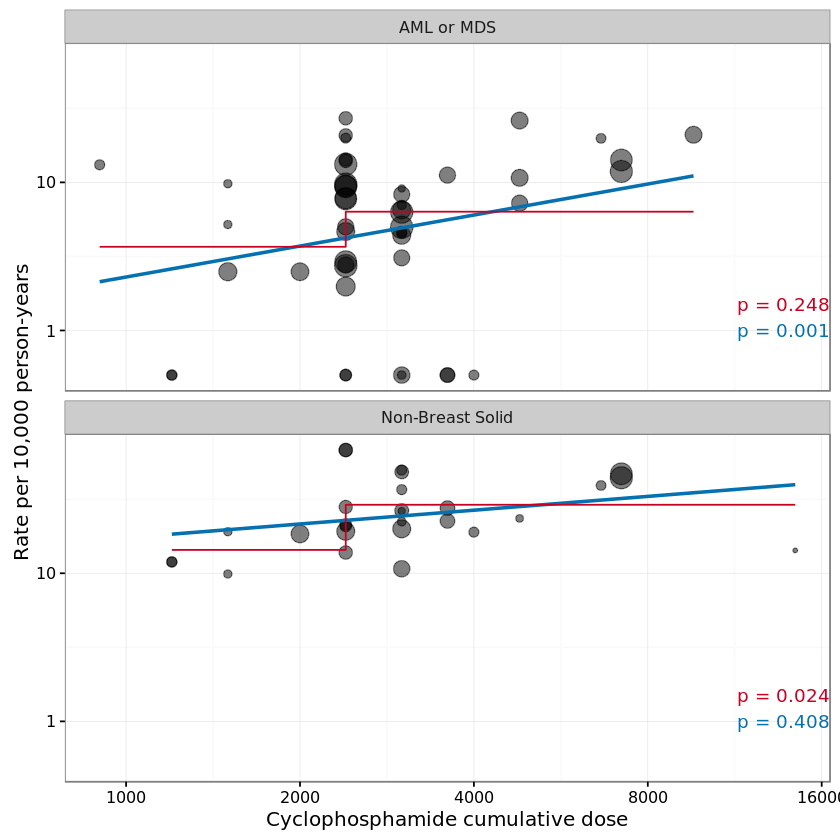

In [18]:
library(metafor)
D2 <- D1[isCyclo == TRUE,
         .(id = factor(id),
           authorYear,
           isCyclo,
           x = cyclophosphamideCumulDose,
           xHighDose = cyclophosphamideCumulDose >= 2400,
           nITT,
           medianFU,
           malType,
           malN,
           py,
           rate)]
M1 <- metareg(D2[malType == "AML or MDS"      ])
M2 <- metareg(D2[malType == "Non-Breast Solid"])
pvalues <- c(M1$pvalueLin, M1$pvalueBin, M2$pvalueLin, M2$pvalueBin)
yhat1 <- unique(data.table(malType = "AML or MDS",
                           xHighDose = as.logical(M1$rma.glmmBin$X[, "mods"]),
                           yhat = invLogit(predict(M1$rma.glmmBin)[["pred"]]) * 10000))
yhat2 <- unique(data.table(malType = "Non-Breast Solid",
                           xHighDose = as.logical(M2$rma.glmmBin$X[, "mods"]),
                           yhat = invLogit(predict(M2$rma.glmmBin)[["pred"]]) * 10000))
yhat <- rbind(yhat1, yhat2)
plotreg(D2,
        "Cyclophosphamide cumulative dose",
        1000 * c(0.5, 1, 2, 4, 8, 16),
        pvalues,
        yhat)

## Study Characteristics and Outcomes

Populate Appendix Table 1.
Need columns for

* Study
* Country
* Median follow-up (months)
* Regimen name
* Cumulative dose
    * Anthracyclines
    * Cyclophosphamide
    * Taxanes
* N
* AML/MDS count (the numerator for the incidence rate)
* Person-years (the denominator for the incidence rate)
* AML/MDS incidence, per 100,000 person-years

Output to an Excel workbook, [appendixTableStudyCharacteristicsAndOutcomes.xlsx](appendixTableStudyCharacteristicsAndOutcomes.xlsx).

In [19]:
library(xlsx)
library(IRdisplay)
library(xtable)
T <- D[,
       .(study = paste(authorYear, trial),
         country = NA,
         medianFU = round(medianFU),
         regimen,
         anthrCumulDose = round(anthracyclineCumulDose),
         cycloCumulaDose = round(cyclophosphamideCumulDose),
         taxaneCumulDose = round(taxaneCumulDose),
         nITT,
         nAMLOrMDS = malAMLOrMDSTotal,
         py = nITT * medianFU,
         incidenceAMLOrMDS = signif(malAMLOrMDSTotal / (nITT * medianFU) * 1e5, digits=3))]
write.xlsx(T,
           "appendixTableStudyCharacteristicsAndOutcomes.xlsx",
           row.names=FALSE,
           showNA=FALSE)
file.info("appendixTableStudyCharacteristicsAndOutcomes.xlsx")
T <- xtable(T, digits=c(rep(0, ncol(T)), 2))
display_html(paste(capture.output(print(T, type = 'html')), collapse="", sep=""))

Loading required package: rJava
Loading required package: xlsxjars

Attaching package: ‘xlsx’

The following objects are masked from ‘package:openxlsx’:

    createWorkbook, loadWorkbook, read.xlsx, saveWorkbook, write.xlsx


Attaching package: ‘xtable’

The following object is masked from ‘package:IRdisplay’:

    display



                                                  size isdir mode
appendixTableStudyCharacteristicsAndOutcomes.xlsx 8681 FALSE  664
                                                                mtime
appendixTableStudyCharacteristicsAndOutcomes.xlsx 2016-06-17 14:51:50
                                                                ctime
appendixTableStudyCharacteristicsAndOutcomes.xlsx 2016-06-17 14:51:50
                                                                atime  uid  gid
appendixTableStudyCharacteristicsAndOutcomes.xlsx 2016-06-17 14:37:34 1000 1000
                                                   uname grname
appendixTableStudyCharacteristicsAndOutcomes.xlsx ubuntu ubuntu

,study,country,medianFU,regimen,anthrCumulDose,cycloCumulaDose,taxaneCumulDose,nITT,nAMLOrMDS,py,incidenceAMLOrMDS
1,Fisher (1990) NSABP B-15,,26,AC,240,2400,,734,,19231,
2,Fisher (1990) NSABP B-15,,26,AC-CMF,240,2400,,728,,19074,
3,Fisher (1990) NSABP B-15,,26,CMF,,,,732,,19178,
4,Misset (1996) NA,,191,CMF,,,,112,,21370,
5,Misset (1996) NA,,191,AVCF,360,14400,,137,,26140,
6,Fisher (1999) NSABP B-25,,55,AC,240,4800,,849,4,46865,8.54
7,Fisher (1999) NSABP B-25,,55,AC,240,4800,,847,10,46754,21.40
8,Fisher (1999) NSABP B-25,,55,AC,240,9600,,849,8,46865,17.10
9,Bergh (2000) SBG 9401,,38,FEC Tailored,,,,251,9,9613,93.60
10,Bergh (2000) SBG 9401,,38,FEC CTCb,180,1200,,274,0,10494,0.00


## Session information

In [20]:
sessionInfo()

R version 3.3.0 (2016-05-03)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.4 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8          LC_NUMERIC=C                 
 [3] LC_TIME=en_US.UTF-8           LC_COLLATE=en_US.UTF-8       
 [5] LC_MONETARY=en_US.UTF-8       LC_MESSAGES=en_US.UTF-8      
 [7] LC_PAPER=en_US.UTF-8          LC_NAME=en_US.UTF-8          
 [9] LC_ADDRESS=en_US.UTF-8        LC_TELEPHONE=en_US.UTF-8     
[11] LC_MEASUREMENT=en_US.UTF-8    LC_IDENTIFICATION=en_US.UTF-8

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] xtable_1.8-2         IRdisplay_0.3.0.9000 xlsx_0.5.7          
 [4] xlsxjars_0.6.1       rJava_0.9-6          RColorBrewer_1.1-2  
 [7] ggplot2_2.1.0        metafor_1.9-8        Matrix_1.2-6        
[10] data.table_1.9.6     openxlsx_3.0.0      

loaded via a namespace (and not attached):
 [1] Rcpp_0.12.5      nloptr_1.0.4     plyr_1.8.3       base64enc